In [208]:
import json
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

print("Hello")

Hello


In [187]:
"""PATH OPERATIONS"""
path = "../results/resultv1/request_data.json"

In [245]:
"""FILE OPERATIONS"""
raw_file = open(path)
raw_json = json.load(raw_file)

ext_metric = raw_json["results"]["first"]["second"][0][0]["values"]
int_metric = raw_json["results"]["first"]["first"][0][0]["values"]


ext_metric_orig = [float(val[1]) for val in ext_metric]
int_metric_orig = [float(val[1]) for val in int_metric]


ext_metric_pd = pd.DataFrame(ext_metric)
ext_metric_pd.rename(columns={0: 'timestamp', 1: 'value'}, inplace=True)
# print(ext_metric[0])
# print(type(ext_metric.get(0)[0]))
ext_metric = ext_metric_pd.get('value')
print(type(ext_metric))


int_metric_pd = pd.DataFrame(int_metric)
int_metric_pd.rename(columns={0: 'timestamp', 1: 'value'}, inplace=True)
int_metric = int_metric_pd.get('value')
print(int_metric)
print(type(int_metric))
print(type(int_metric[0]))






<class 'pandas.core.series.Series'>
0         662.4950801639945
1         662.4950801639945
2         662.4950801639945
3         662.4950801639945
4         666.3950801639945
                ...        
10799    1520.1106870229007
10800    1520.1106870229007
10801    1521.2014836907792
10802    1521.2014836907792
10803    1521.2014836907792
Name: value, Length: 10804, dtype: object
<class 'pandas.core.series.Series'>
<class 'str'>


In [189]:
""" STANDARDIZATION """

# Initialize the StandardScaler
scaler = StandardScaler()

# Reshape the data for the scaler
ext_values_orig_reshaped = np.array(ext_metric_orig).reshape(-1, 1)
int_values_orig_reshaped = np.array(int_metric_orig).reshape(-1, 1)

# Fit and transform the original external and internal data
ext_values_standardized = scaler.fit_transform(ext_values_orig_reshaped).flatten()
int_values_standardized = scaler.fit_transform(int_values_orig_reshaped).flatten()

In [210]:
""" NORMALIZATION """
min_max_scaler = MinMaxScaler()  # Initialize the MinMaxScaler
ext_values_orig_reshaped = np.array(ext_metric_orig).reshape(-1, 1)
int_values_orig_reshaped = np.array(int_metric_orig).reshape(-1, 1)
ext_values_normalized = min_max_scaler.fit_transform(ext_values_orig_reshaped).flatten()
int_values_normalized = min_max_scaler.fit_transform(int_values_orig_reshaped).flatten()

In [244]:
""" SUPREMUM SETTING """

max = ext_metric.to_numpy().max()
print(max)



# reduced_int_metric_values_corrected = [
#     [time, str(min(float(value), max))] for time, value in int_metric
# ]

reduced_int_metric_values_corrected = [
    str(min(float(value), float(max))) for value in int_metric
]


print(reduced_int_metric_values_corrected)
print(type(reduced_int_metric_values_corrected))

930.5250460000001
['662.4950801639945', '662.4950801639945', '662.4950801639945', '662.4950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '666.3950801639945', '676.5905303156561', '677.9905303156562', '677.9905303156562', '677.9905303156562', '677.9905303156562', '759.8030970732257', '759.8030970732257', '759.8030970732257', '759.8030970732257', '759.8030970732257', '759.8030970732257', '759.8030970732257', '759.8030970732257', '758.4030970732257', '758.4030970732257', '758.4030970732257', '758.4030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732257', '760.0030970732

In [246]:
"""OVERLAP"""
buffer = 75

# ext_values_orig = [float(val[1]) for val in ext_metric_orig]
# int_values_orig = [float(val[1]) for val in int_metric_orig]
min_len_original = min(len(ext_metric_orig), len(int_metric_orig))
ext_values_orig = ext_metric_orig[:min_len_original]
int_values_orig = int_metric_orig[:min_len_original]

overlap_count = sum(1 for ext_val, int_val in zip(ext_values_orig, int_values_orig) if abs(ext_val - int_val) <= buffer)
print("Number of overlaps:", overlap_count)



Number of overlaps: 6932


In [247]:
"""OVERLAP RETRIEVAL"""
refined_ext_values = []
refined_int_values = []

for ext_val, int_val in zip(ext_values_orig, int_values_orig):
    if abs(ext_val - int_val) <= buffer:
        refined_ext_values.append(ext_val)
        refined_int_values.append(int_val)


refined_correlation_coefficient = np.corrcoef(refined_ext_values, refined_int_values)[0, 1]
print("Correlation with only overlapping values:",refined_correlation_coefficient)

Correlation with only overlapping values: 0.26816393100692654


In [112]:
"""THRESHOLD APPLICATION"""

threshold = 900

# Exclude all indices where the value is above the threshold from both lists
ext_values_filtered = [value for value in refined_ext_values if value <= threshold]
int_values_filtered = [value for value in refined_int_values if value <= threshold]
print(len(int_values_filtered))
# Ensure both lists are of equal length after filtering
min_length_filtered = min(len(ext_values_filtered), len(int_values_filtered))
trimmed_ext_filtered = ext_values_filtered[:min_length_filtered]
trimmed_int_filtered = int_values_filtered[:min_length_filtered]

# Recalculate the correlation with the filtered data
correlation_coefficient_filtered = np.corrcoef(trimmed_ext_filtered, trimmed_int_filtered)[0, 1]
print("Correlation if values above 1000 Watt removed (spike removal first attempt):", correlation_coefficient_filtered)

7147
Correlation if values above 1000 Watt removed (spike removal first attempt): 0.12174648455296852


In [242]:
# base_corr = ext_metric.corr(int_metric)
# base_corr = ext_values_standardized.corr(int_values_standardized)

# ext_metric_std = pd.DataFrame(ext_values_standardized)
# print(ext_metric_std)
# int_metric_std = pd.DataFrame(int_values_standardized)
# print(int_metric_std)
# base_corr = ext_metric_std[0].corr(int_metric_std[0])


# ext_metric_norm = pd.DataFrame(ext_values_normalized)
# int_metric_norm = pd.DataFrame(int_values_standardized)
# base_corr = ext_metric_norm[0].corr(int_metric_norm[0])

# base_corr = pd.Series(reduced_int_metric_values_corrected).corr(ext_metric)
base_corr = pd.to_numeric(pd.Series(reduced_int_metric_values_corrected)).corr(pd.to_numeric(ext_metric))



# sizes must fit
# base_corrcoef = np.corrcoef(ext_metric, int_metric)[0,1]

print("Basic Correlation:",base_corr)
# print("Basic corrcoef:", base_corrcoef)

Basic Correlation: 0.01766717668379596


In [248]:
# Savitzky-Golay filter

# number of points to compute smoothed value
window_length = 51
# window_length = 33
# how strong the data is smoothed
polyorder = 1


ext_metric_smooth= savgol_filter(refined_ext_values, window_length, polyorder)
int_metric_smooth = savgol_filter(refined_int_values, window_length, polyorder)
# ext_metric_smooth= savgol_filter(trimmed_ext_filtered, window_length, polyorder)
# int_metric_smooth = savgol_filter(trimmed_int_filtered, window_length, polyorder)



# smoothed_corr = pd.DataFrame(ext_metric_smooth).corr(pd.DataFrame(int_metric_smooth))
# print("Smoothed correlation", smoothed_corr)

correlation_coef = np.corrcoef(ext_metric_smooth, int_metric_smooth)[0, 1]
print("Smoothed corrcoef:", correlation_coef)



Smoothed corrcoef: 0.589010770624722


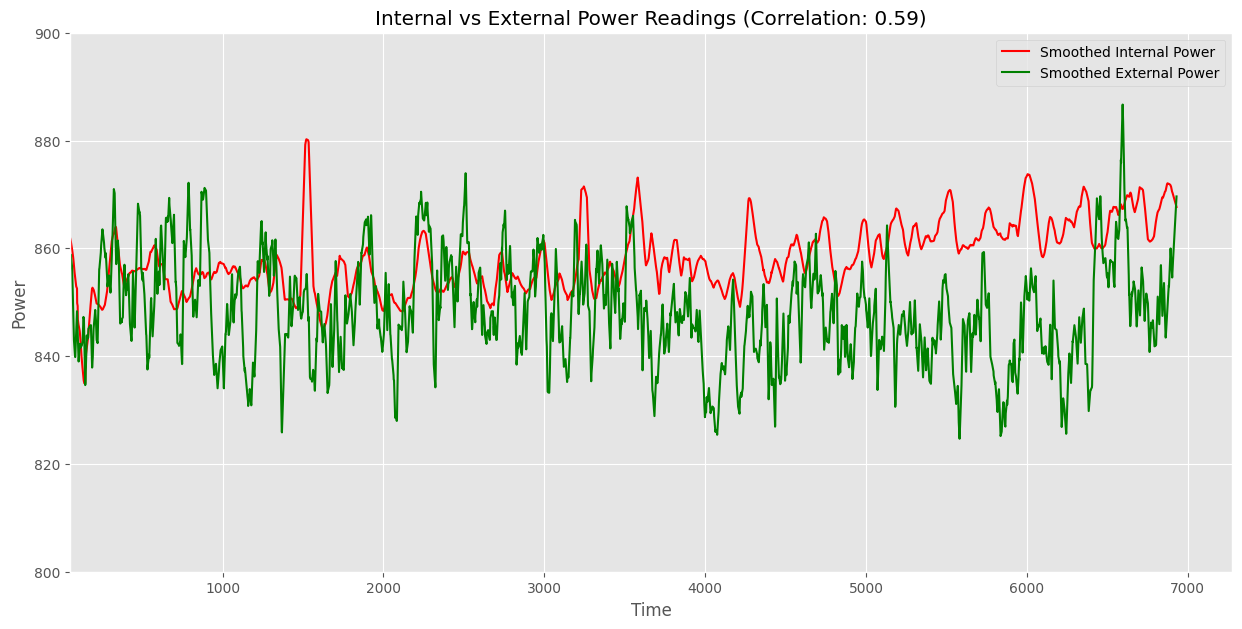

In [266]:
# Plot the original and smoothed data


plt.style.use('ggplot')  # Replace 'seaborn' with 'ggplot' or another available style
plt.figure(figsize=(15, 7), dpi=100)  # Adjust DPI for better resolution
# plt.plot(int_metric_pd.index, int_metric, label='Original Internal Power', alpha=0.5)
plt.plot(int_metric_smooth, label='Smoothed Internal Power', color='red')
# plt.plot(ext_metric_pd.index, ext_metric, label='Original External Power', alpha=0.5)
plt.plot(ext_metric_smooth, label='Smoothed External Power', color='green')
plt.xlim(left=50)  # Adjust 'left' to the desired starting point of your x-axis
plt.ylim(bottom=800, top=900)  # Adjust 'bottom' and 'top' to the desired y-axis limits

plt.legend()
plt.title(f'Internal vs External Power Readings (Correlation: {correlation_coef:.2f})')
plt.xlabel('Time')
plt.ylabel('Power')
plt.show()